In [1]:
import pandas as pd
from sklearn import model_selection
from sklearn.compose import(
    make_column_selector as selector,
    ColumnTransformer,
)

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('adult_cencus.csv')
df.sample(n=5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,class
40383,33,Private,234537,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
26248,65,Private,180807,HS-grad,9,Separated,Protective-serv,Not-in-family,White,Male,991,0,20,United-States,<=50K
5698,51,Private,240988,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,<=50K
39304,35,Local-gov,184117,Masters,14,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
28943,23,NaN,86337,Some-college,10,Never-married,NaN,Not-in-family,White,Female,0,0,15,United-States,<=50K


In [3]:
df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
class                0
dtype: int64

In [4]:
data, target = df.drop(columns=['education_num', 'class']), df['class'].map({' >50K':1, ' <=50K':0})

In [5]:
target.isna().sum()

0

In [6]:
X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
    data,
    target,
    test_size=.2,
    random_state=42
)

X_full_train.shape, y_full_train.shape, X_test.shape, y_test.shape

((39073, 13), (39073,), (9769, 13), (9769,))

In [7]:
categorical = selector(dtype_include=object)(data)
cat_preprocessor = OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1
)

preprocessor = ColumnTransformer([
    ('cat_preprocessor', cat_preprocessor, categorical)
],
remainder='passthrough', sparse_threshold=0
)

In [8]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

In [9]:
for param in model.get_params():
  print(param)

memory
steps
verbose
preprocessor
classifier
preprocessor__n_jobs
preprocessor__remainder
preprocessor__sparse_threshold
preprocessor__transformer_weights
preprocessor__transformers
preprocessor__verbose
preprocessor__verbose_feature_names_out
preprocessor__cat_preprocessor
preprocessor__cat_preprocessor__categories
preprocessor__cat_preprocessor__dtype
preprocessor__cat_preprocessor__handle_unknown
preprocessor__cat_preprocessor__unknown_value
classifier__categorical_features
classifier__early_stopping
classifier__l2_regularization
classifier__learning_rate
classifier__loss
classifier__max_bins
classifier__max_depth
classifier__max_iter
classifier__max_leaf_nodes
classifier__min_samples_leaf
classifier__monotonic_cst
classifier__n_iter_no_change
classifier__random_state
classifier__scoring
classifier__tol
classifier__validation_fraction
classifier__verbose
classifier__warm_start


# Tuning hyperparameters manually

Make a search of the best combinations of the `learning_rate` and `max_leaf_nodes`

In [10]:
best_params = {}
score = 0

for lr in [0.01, 0.1, 1, 10.]:
  for leaf in [3, 10, 30]:
    model.set_params(
        classifier__learning_rate=lr, 
        classifier__max_leaf_nodes=leaf
    )

    cv_score = model_selection.cross_val_score(
        model,
        X_full_train,
        y_full_train,
        cv=10,
        n_jobs=-1
    )
    if cv_score.mean() > score:
      score = cv_score.mean()
      best_params['lr'] = lr
      best_params['max_leaf_nodes'] = leaf
      best_params['score'] = score
      best_params['std'] = score.std()
    
    print(f"lr:{lr} - max-leaf-nodes:{leaf} - score:{cv_score.mean():.3f} "
          f"std: {cv_score.std():.3f}"
    )
print()
print(f"best lr: {best_params['lr']}, best max leaf nodes:{best_params['max_leaf_nodes']} "
      f"best score: {best_params['score']:.3f} +/- {best_params['std']:.3f}"
)

lr:0.01 - max-leaf-nodes:3 - score:0.800 std: 0.003
lr:0.01 - max-leaf-nodes:10 - score:0.820 std: 0.004
lr:0.01 - max-leaf-nodes:30 - score:0.849 std: 0.004
lr:0.1 - max-leaf-nodes:3 - score:0.855 std: 0.004
lr:0.1 - max-leaf-nodes:10 - score:0.871 std: 0.005
lr:0.1 - max-leaf-nodes:30 - score:0.874 std: 0.004
lr:1 - max-leaf-nodes:3 - score:0.866 std: 0.005
lr:1 - max-leaf-nodes:10 - score:0.866 std: 0.006
lr:1 - max-leaf-nodes:30 - score:0.860 std: 0.010
lr:10.0 - max-leaf-nodes:3 - score:0.279 std: 0.008
lr:10.0 - max-leaf-nodes:10 - score:0.743 std: 0.082
lr:10.0 - max-leaf-nodes:30 - score:0.656 std: 0.161

best lr: 0.1, best max leaf nodes:30 best score: 0.874 +/- 0.000


In [11]:
model.set_params(
    classifier__learning_rate=best_params['lr'], 
    classifier__max_leaf_nodes=best_params['max_leaf_nodes']
)

model.fit(X_full_train, y_full_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=30,
                                                random_state=42))])

In [12]:
y_pred = model.predict(X_test)

In [13]:
y_pred[:5]

array([0, 0, 0, 0, 0])

In [14]:
score = model.score(X_test, y_test)
score.round(3)

0.874

In [16]:
from sklearn import metrics

recall_score = metrics.recall_score(y_test, y_pred)
pecision_score = metrics.precision_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

print(f'recall: {recall_score:.3f}')
print(f'precision: {pecision_score:.3f}')
print(f'auc: {auc:.3f}')

recall: 0.642
precision: 0.795
auc: 0.795


# Hyperparameter tuning by grid-search

In [18]:
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 1, 10], 
    'classifier__max_leaf_nodes': [3, 10, 30],
}

model_grid_search = model_selection.GridSearchCV(
    model,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1

).fit( X_full_train,y_full_train)

In [19]:
accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.87


The `GridSearchCV` estimator takes a `param_grid` parameter which defines all hyperparameters and their associated values. The grid-search will be in charge of creating all possible combinations and test them.

The number of combinations will be equal to the product of the number of values to explore for each parameter (e.g. in our example 4 x 3 combinations). Thus, adding new parameters with their associated values to be explored become rapidly computationally expensive.

Once the grid-search is fitted, it can be used as any other predictor by calling `predict` and `predict_proba`. Internally, it will use the model with the best parameters found during `fit`.

You can know about these parameters by looking at the `best_params_` attribute.

In [20]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}"
)

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


The accuracy and the best parameters of the grid-searched pipeline are similar to the ones we found in the previous exercise, where we searched the best parameters "by hand" through a double for loop.

In addition, we can inspect all results which are stored in the attribute `cv_results_` of the grid-search. We will filter some specific columns from these results.


In [21]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score",
    ascending=False
)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
5,2.833829,0.038581,0.098685,0.016626,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.878199,0.873081,0.876663,0.877655,0.868953,0.875096,0.869977,0.867929,0.874328,0.880983,0.874286,0.004083,1
4,2.367050,0.059774,0.081676,0.010385,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.874360,0.866428,0.873849,0.876888,0.866650,0.868185,0.863322,0.865114,0.872792,0.877655,0.870524,0.004906,2
6,1.689116,0.102000,0.048815,0.009528,1,3,"{'classifier__learning_rate': 1, 'classifier__...",0.868219,0.861566,0.869754,0.877400,0.861275,0.868441,0.863066,0.862554,0.864858,0.860251,0.865738,0.005011,3
7,1.538802,0.084523,0.041000,0.006003,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.868219,0.857472,0.871290,0.870745,0.863578,0.866394,0.860763,0.854620,0.869721,0.873816,0.865662,0.006041,4
8,1.592369,0.178050,0.041580,0.007018,1,30,"{'classifier__learning_rate': 1, 'classifier__...",0.869243,0.857472,0.832139,0.867673,0.859227,0.864858,0.855388,0.862042,0.861787,0.868441,0.859827,0.010250,5


In [24]:
column_results = [f'param_{name}' for name in param_grid.keys()]
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']
cv_results = cv_results[column_results]
cv_results.columns = cv_results.columns.str.replace('param_classifier__', '')
cv_results.head()

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.1,30,0.874286,0.004083,1
4,0.1,10,0.870524,0.004906,2
6,1,3,0.865738,0.005011,3
7,1,10,0.865662,0.006041,4
8,1,30,0.859827,0.010250,5




With only 2 parameters, we might want to visualize the grid-search as a heatmap. We need to transform our `cv_results` into a dataframe where:

- the rows will correspond to the learning-rate values;
- the columns will correspond to the maximum number of leaf;
- the content of the dataframe will be the mean test scores.



In [25]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.800194,0.820413,0.849410
0.10,0.855296,0.870524,0.874286
1.00,0.865738,0.865662,0.859827
10.00,0.278965,0.742533,0.655650


We can use a heatmap representation to show the above dataframe visually.

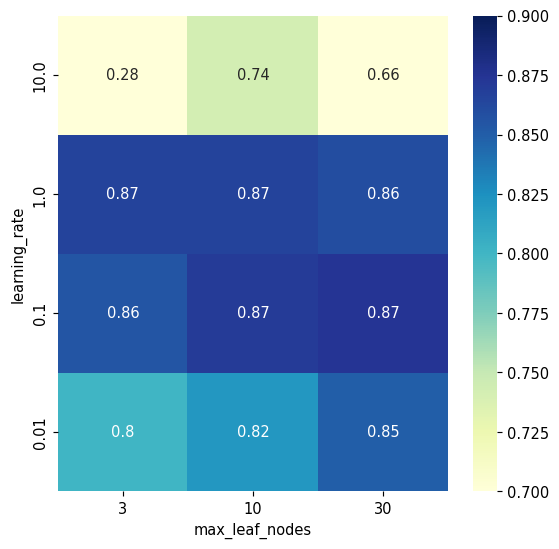

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(6,6), dpi=105)
ax = sns.heatmap(
    pivoted_cv_results, 
    annot=True,
    cmap="YlGnBu", 
    vmin=0.7,
    vmax=0.9
)

ax.invert_yaxis()

The above tables highlights the following things:

* for too high values of `learning_rate`, the generalization performance of the model is degraded and adjusting the value of `max_leaf_nodes` cannot fix that problem;

* outside of this pathological region, we observe that the optimal choice of `max_leaf_nodes` depends on the value of `learning_rate`;

* in particular, we observe a "diagonal" of good models with an accuracy close to the maximal of 0.87: when the value of `max_leaf_nodes` is increased, one should decrease the value of `learning_rate` accordingly to preserve a good accuracy.


We can conclude:
* that searching for more than two hyperparamters is too costly;
* that a grid-search does not necessarily find an optimal solution.

# Hyperparameter tuning by randomized-search

A grid-search approach has limitations. It does not scale when the number of parameters to tune is increasing. Also, the grid will impose a regularity during the search which might be problematic. However, we will present another method to tune hyperparameters called randomized search.

We will optimize 3 other parameters in addition to the ones we optimized with the `GridSearchCV`:

* `l2_regularization`: it corresponds to the strength of the regularization;
* `min_samples_leaf`: it corresponds to the minimum number of samples required in a leaf;
* `max_bins`: it corresponds to the maximum number of bins to construct the histograms.

We recall the meaning of the 2 remaining parameters:

* `learning_rate`: it corresponds to the speed at which the gradient-boosting will correct the residuals at each boosting iteration;
* `max_leaf_nodes`: it corresponds to the maximum number of leaves for each tree in the ensemble.


The `RandomizedSearchCV` class allows for such stochastic search. It is used similarly to the `GridSearchCV` but the sampling distributions need to be specified instead of the parameter values. For instance, we will draw candidates using a **log-uniform** distribution because the parameters we are interested in take positive values with a natural log scaling *(.1 is as close to 1 as 10 is)*.


In [28]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


Now, we can define the randomized search using the different distributions.

In [38]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions,
    n_iter=500,
    cv=5,
    verbose=1,
).fit(X_full_train, y_full_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
CPU times: user 1h 9min 59s, sys: 1min 23s, total: 1h 11min 23s
Wall time: 39min 2s


Then, we can compute the accuracy score on the test set.

In [39]:
accuracy = model_random_search.score(X_test, y_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}"
)


The test accuracy score of the best model is 0.87


In [40]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 0.021329648717648208,
 'classifier__learning_rate': 0.1307886059282795,
 'classifier__max_bins': 157,
 'classifier__max_leaf_nodes': 29,
 'classifier__min_samples_leaf': 2}


We can inspect the results using the attributes cv_results as we did previously.

In [41]:
column_results = [f'param_{name}' for name in param_distributions.keys()]
column_results += ['mean_test_score', 'std_test_score', 'rank_test_score']

cv_results = pd.DataFrame(model_random_search.cv_results_).sort_values(
    "mean_test_score",
    ascending=False
)
cv_results = cv_results[column_results]

cv_results.columns = cv_results.columns.str.replace('param_classifier__', '')
cv_results.head()

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
390,0.02133,0.130789,29,2,157,0.873288,0.003448,1
116,0.000023,0.210858,31,9,188,0.871958,0.003403,2
108,0.000009,0.429032,6,51,191,0.871830,0.003433,3
157,0.000089,0.051247,114,1,137,0.871753,0.003713,4
163,1.797504,0.040984,107,3,132,0.871574,0.003413,5
